# Requirements

In [236]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# **Tumor Detection Workflow**

1. **Load the MRI Brain Image**  
   Import the magnetic resonance imaging (MRI) scan of the brain.

2. **Brain Region Extraction**  
   Isolate and extract only the brain region from the MRI image, removing non-brain areas.

3. **Tumor Segmentation**  
   Detect and segment the tumor region from the extracted brain area.

4. **Tumor Size Calculation**  
   Measure and calculate the size (area or volume) of the segmented tumor.

# Load image

Define the path to the image.

In [237]:
image_path = "image-2.jpg"

Read the image.

In [238]:
image = cv2.imread(image_path)

Resize the image to width and height of 256 pixels.

In [239]:
resized_image = cv2.resize(image, (256, 256))

Convert the image from BGR to grayscale.

In [240]:
grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

Show the image.

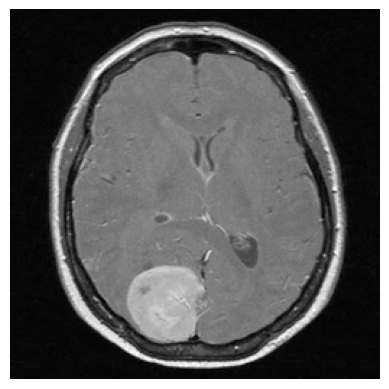

In [241]:
plt.imshow(grayscale_image, cmap="gray")
plt.axis("off");

If the pixels in the image can be classified into two different intensity classes, that is, if they have a bimodal histogram, then **Otsu's method** can be used to threshold them into a binary mask. Let's check that assumption.

Make a histogram of the intensities in the grayscale image.

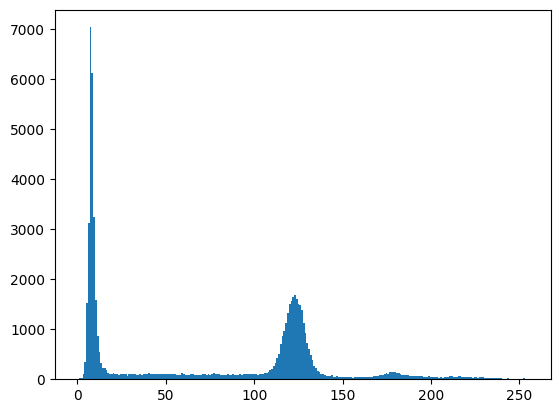

In [242]:
plt.hist(grayscale_image.ravel(),256)
plt.show()

In [243]:
_, thresh = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_OTSU)

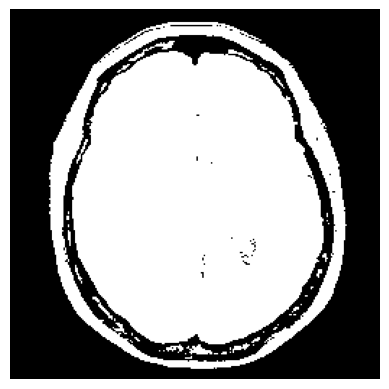

In [244]:
plt.imshow(thresh, cmap="gray")
plt.axis("off");

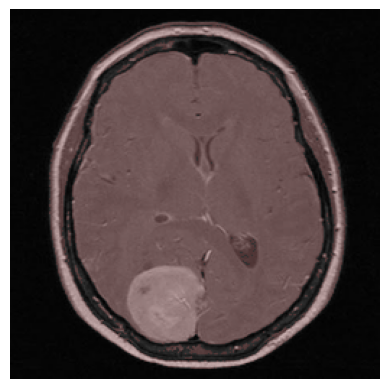

In [245]:
colormask = np.zeros(resized_image.shape, dtype=np.uint8)
colormask[thresh != 0] = np.array((0, 0, 255))
blended = cv2.addWeighted(resized_image, 0.7, colormask, 0.1,0)
plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
plt.axis("off");

In [246]:
ret, markers = cv2.connectedComponents(thresh)

Get the area taken by each component. Ignore label 0 since this is the background.

In [247]:
marker_area = [np.sum(markers == m) for m in range(np.max(markers)) if m != 0] 

Get label of largest component by area.

In [248]:
largest_component = np.argmax(marker_area) + 1 # Add 1 since we dropped zero above.

Get pixels which correspond to the brain.

In [249]:
brain_mask = markers == largest_component

In a copy of the original image, clear those pixels that don't correspond to the brain.

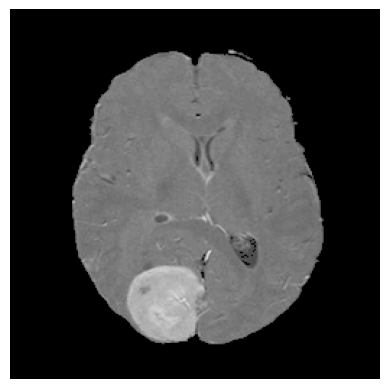

In [250]:
brain_out = resized_image.copy()
brain_out[brain_mask == False] = (0, 0, 0)
plt.imshow(brain_out)
plt.axis("off");

In [251]:
brain_image = cv2.cvtColor(brain_out, cv2.COLOR_BGR2GRAY)

Apply Gaussian blur to the segmented brain.

In [252]:
blurred_image = cv2.GaussianBlur(brain_image, (3, 3), 0)

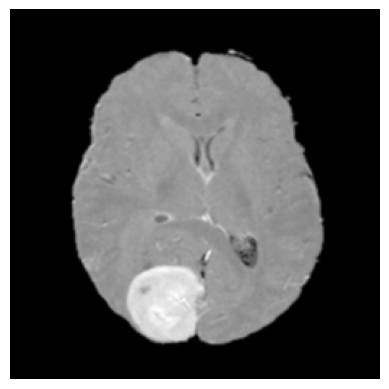

In [253]:
plt.imshow(blurred_image, cmap="gray")
plt.axis("off");

Reshape the image for K-means clustering.

In [254]:
Z = np.float32(blurred_image.reshape((-1,1)))

Define the criteria and apply K-means.

In [255]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3  # Number of clusters (brain, tumor, background).
_, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

Reshape labels to the original image shape.

In [256]:
segmented = labels.reshape(blurred_image.shape).astype("uint8")

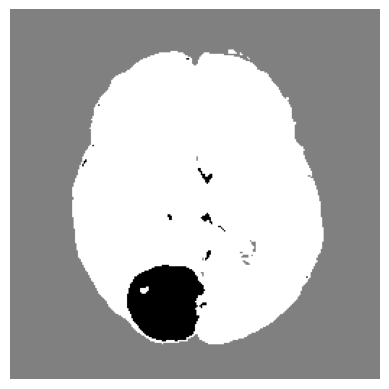

In [257]:
plt.imshow(segmented, cmap="gray")
plt.axis("off");

Convert the tumor cluster to binary mask.

In [258]:
tumor_mask = np.zeros_like(blurred_image)
tumor_mask[segmented == np.argmax(centers)] = 255  # Define the mask.

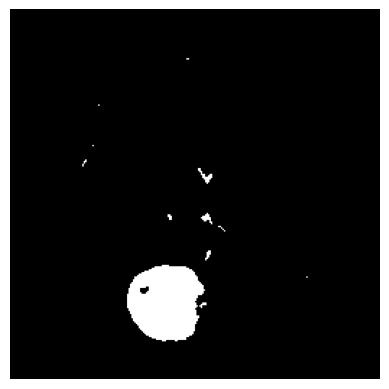

In [259]:
plt.imshow(tumor_mask, cmap="gray")
plt.axis("off");

**Morphological Operations**

1. Erosion
- Erosion is a fundamental morphological operation that reduces the size of objects in a binary image. It works by removing pixels from the boundaries of objects.
- Purpose: To remove small noise, detach connected objects, and erode boundaries.
- How it Works: The structuring element slides over the image, and for each position, if all the pixels under the structuring element match the foreground, the pixel in the output image is set to the foreground. Otherwise, it is set to the background.

2. Dilation
- Dilation is the opposite of erosion and is used to increase the size of objects in an image.
- Purpose: To join adjacent objects, fill small holes, and enhance features.
How it Works: The structuring element slides over the image, and for each position, if any pixel under the structuring element matches the foreground, the pixel in the output image is set to the foreground.
3. Opening
- Opening is a compound operation that involves erosion followed by dilation.
- Purpose: To remove small objects or noise from the image while preserving the shape and size of larger objects.
- How it Works: First, the image undergoes erosion, which removes small objects and noise. Then, dilation is applied to restore the size of the remaining objects to their original dimensions.
4. Closing
- Closing is another compound operation that consists of dilation followed by erosion.
- Purpose: To fill small holes and gaps in objects while preserving their overall shape.
- How it Works: First, dilation is applied to the image, filling small holes and gaps. Then, erosion is applied to restore the original size of the objects.

Perform morphological operations to refine segmentation.

In [260]:
kernel = np.ones((7, 7), np.uint8)
tumor_mask0 = cv2.morphologyEx(tumor_mask, cv2.MORPH_OPEN, kernel)

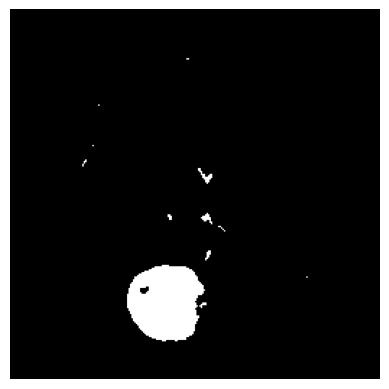

In [261]:
plt.imshow(tumor_mask, cmap="gray")
plt.axis("off");

Find contours and select the largest one (likely the tumor).

In [262]:
contours, _ = cv2.findContours(tumor_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

Create a final mask for the tumor.

In [263]:
final_mask = np.zeros_like(brain_image)
if contours:
    cv2.drawContours(final_mask, [contours[0]], -1, (255, 0, 0), thickness=cv2.FILLED)

Display the results.

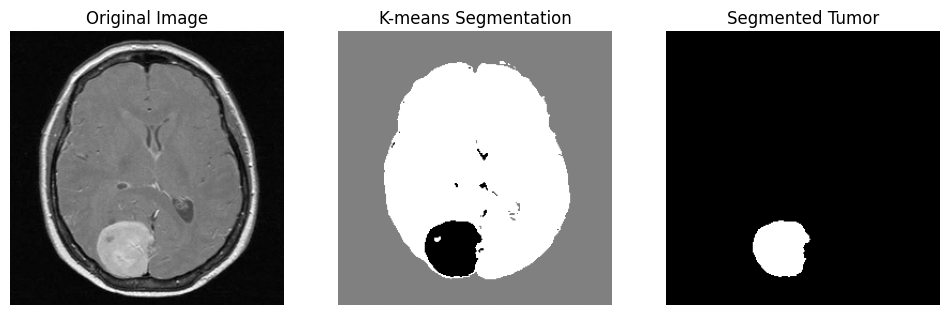

In [264]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.axis("off");

plt.subplot(1, 3, 2)
plt.title("K-means Segmentation")
plt.imshow(segmented, cmap="gray")
plt.axis("off");

plt.subplot(1, 3, 3)
plt.title("Segmented Tumor")
plt.imshow(final_mask, cmap="gray")
plt.axis("off");

plt.show()

Extract the contour of the tumor.

In [265]:
tumor_contour = contours[0] # This is the largest contour.
tumor_area_px = cv2.contourArea(tumor_contour)  # Get the area of the largest contour in pixels.

Get bounding box around the tumor.

In [266]:
x, y, w, h = cv2.boundingRect(tumor_contour)

Assume pixel spacing (modify as needed).

In [267]:
pixel_spacing = 0.5  # Example: 0.5 mm per pixel.

Convert area to mm².

In [268]:
tumor_area_mm2 = tumor_area_px * (pixel_spacing ** 2)

In [269]:
print(f"Tumor Size in Pixels: {tumor_area_px} px²")
print(f"Tumor Size in mm²: {tumor_area_mm2:.2f} mm²")
print(f"Tumor Bounding Box: Width={w}px, Height={h}px")

Tumor Size in Pixels: 2098.5 px²
Tumor Size in mm²: 524.62 mm²
Tumor Bounding Box: Width=54px, Height=53px


Draw bounding box around the tumor.

In [270]:
bounding_box = cv2.rectangle(resized_image.copy(), (x, y), (x + w, y + h), (0, 0, 255), 1)

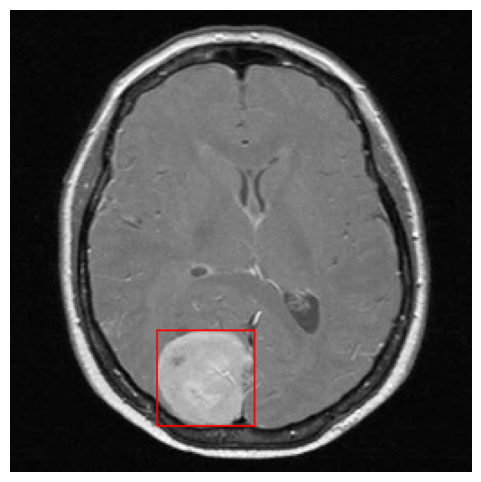

In [271]:
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(bounding_box, cv2.COLOR_BGR2RGBA))
plt.axis("off");

Draw a contour around the tumor.

In [272]:
contour_image = cv2.drawContours(resized_image.copy(), contours, 0, (0, 0, 255), thickness=1)

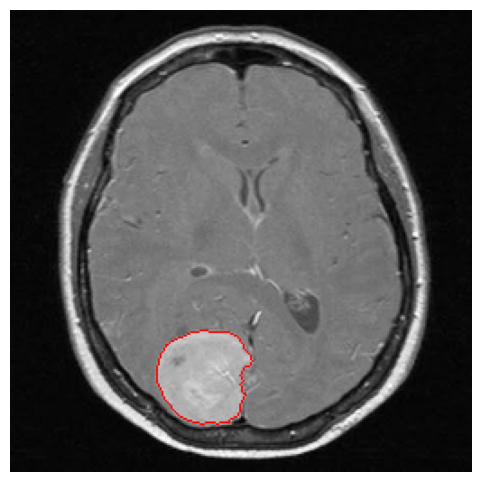

In [273]:
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.axis("off");